# Part 1: Email spam classification [50 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**Remark**: We begin with some boilerplate imports. Also, for the solutions, we initialize a **single** random number generator with random seed 0 once at the beginning (you did not have to do this). In practice, some times people will write code in this way if there are lots of randomized procedures being run, and rather than having every single one of these random procedures be given a random seed of 0 (or some other constant), we just keep working with a single random number generator that has been seeded initially (so that the code output is reproducible).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

rng = np.random.RandomState(0)

### Print the number of ham and spam emails [1 point]
 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it?

In [2]:
spam_count = len(glob('./email-data/spam/*.txt'))
ham_count = len(glob('./email-data/ham/*.txt'))
print(spam_count)
print(ham_count)

3671
1500


While there's class imbalance (in particular a lot more spam than ham examples), the class imbalance is not extreme (e.g., where one class takes up 99% of the total number of examples). To deal with this class imbalance, we use stratified k-fold cross-validation later instead of standard k-fold cross-validation to preserve the class proportions per fold (stratified k-fold cross-validation just enforces that the same proportion of each class is sampled per fold as the overall training data). Again, since the class imbalance is actually not that extreme, this sort of precaution isn't actually necessary. Note that if instead the class imbalance were extreme, a strategy like stratified k-fold cross-validation could be essential to ensure that enough minority class examples actually show up in each fold.

### Construct the documents [4 points]
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [3]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [4]:
documents = [makeWordList(filename) for filename in glob('./email-data/spam/*.txt')] \
    + [makeWordList(filename) for filename in glob('./email-data/ham/*.txt')]
labels = np.concatenate((np.ones(spam_count), np.zeros(ham_count)))
print(len(documents))

5171


### Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=50, max_df=0.8, stop_words="english")
X = vectorizer.fit_transform(documents)
print(len(vectorizer.vocabulary_))

1680


### k-NN, SVM, random forest: Hyperparameter selection [20 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function in `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - SVM: (SVC) Select `C` from a range of your choice, use any kernel that performs well.
   - Random forest: Select `n_estimators` **and** `max_depth` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_C`, `best_n_estimators`, and `best_max_depth` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [6]:
# To deal with class imbalance, we explicitly use StratifiedKFold
# instead of KFold (note that you did not have to do this)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [7]:
from sklearn.neighbors import KNeighborsClassifier

num_folds = 5
k_fold = StratifiedKFold(num_folds, random_state=rng)
param_values = np.arange(1, 6, 1)

arg_max = -np.inf
best_k = None
for i in param_values:
    fold_scores = []
    print("k = " + str(i))
    for k, (train, val) in enumerate(k_fold.split(X, labels)):
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X[train], labels[train])
        
        ypred = clf.predict(X[val])
        yval = labels[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        print("\t[fold {0}] k: {1:.5f}, accuracy: {2:.5f}".format(k, i, a))
        
    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))
    
    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_k = i
            
print('Best k:', best_k)

k = 1
	[fold 0] k: 1.00000, accuracy: 0.93947
	[fold 1] k: 1.00000, accuracy: 0.93656
	[fold 2] k: 1.00000, accuracy: 0.93726
	[fold 3] k: 1.00000, accuracy: 0.93846
	[fold 4] k: 1.00000, accuracy: 0.93510
	Mean F1 score: 0.9373704451004355
k = 2
	[fold 0] k: 2.00000, accuracy: 0.93897
	[fold 1] k: 2.00000, accuracy: 0.92931
	[fold 2] k: 2.00000, accuracy: 0.93103
	[fold 3] k: 2.00000, accuracy: 0.93695
	[fold 4] k: 2.00000, accuracy: 0.93592
	Mean F1 score: 0.9344384229088231
k = 3
	[fold 0] k: 3.00000, accuracy: 0.91924
	[fold 1] k: 3.00000, accuracy: 0.91487
	[fold 2] k: 3.00000, accuracy: 0.90837
	[fold 3] k: 3.00000, accuracy: 0.91405
	[fold 4] k: 3.00000, accuracy: 0.91149
	Mean F1 score: 0.9136051545147327
k = 4
	[fold 0] k: 4.00000, accuracy: 0.93645
	[fold 1] k: 4.00000, accuracy: 0.92596
	[fold 2] k: 4.00000, accuracy: 0.92636
	[fold 3] k: 4.00000, accuracy: 0.94806
	[fold 4] k: 4.00000, accuracy: 0.91985
	Mean F1 score: 0.9313370501295493
k = 5
	[fold 0] k: 5.00000, accuracy

In [8]:
from sklearn import svm

num_folds = 5
k_fold = StratifiedKFold(num_folds, random_state=rng)
param_values = np.logspace(-4, 2, 3)

arg_max = -np.inf
best_C = None
for C in param_values:
    fold_scores = []
    print("C = " + str(C))
    for k, (train, val) in enumerate(k_fold.split(X, labels)):
        clf = svm.LinearSVC(C=C)
        clf.fit(X[train], labels[train])
        
        ypred = clf.predict(X[val])
        yval = labels[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        print("\t[fold {0}] C: {1:.5f}, accuracy: {2:.5f}".format(k, C, a))
        
    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))
    
    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_C = C
            
print('Best C:', best_C)

C = 0.0001
	[fold 0] C: 0.00010, accuracy: 0.93366
	[fold 1] C: 0.00010, accuracy: 0.91652
	[fold 2] C: 0.00010, accuracy: 0.92405
	[fold 3] C: 0.00010, accuracy: 0.93780
	[fold 4] C: 0.00010, accuracy: 0.92298
	Mean F1 score: 0.9270005183900499
C = 0.1
	[fold 0] C: 0.10000, accuracy: 0.99419
	[fold 1] C: 0.10000, accuracy: 0.98445
	[fold 2] C: 0.10000, accuracy: 0.98446
	[fold 3] C: 0.10000, accuracy: 0.99225
	[fold 4] C: 0.10000, accuracy: 0.98638
	Mean F1 score: 0.9883453627502977
C = 100.0
	[fold 0] C: 100.00000, accuracy: 0.99128
	[fold 1] C: 100.00000, accuracy: 0.97868
	[fold 2] C: 100.00000, accuracy: 0.97874
	[fold 3] C: 100.00000, accuracy: 0.98551
	[fold 4] C: 100.00000, accuracy: 0.97284
	Mean F1 score: 0.9814122416072646
Best C: 0.1


In [9]:
from sklearn.ensemble import RandomForestClassifier

num_folds = 5
k_fold = StratifiedKFold(num_folds, random_state=rng)
param_values = [(n_estimators, max_depth)
                for n_estimators in [50, 100, 150, 200]
                for max_depth in [50, 100, 150]]

arg_max = -np.inf
best_arg = None
for n_estimators, max_depth in param_values:
    fold_scores = []
    print("n_estimators = " + str(n_estimators)
          + ', max_depth = ' + str(max_depth))
    for k, (train, val) in enumerate(k_fold.split(X, labels)):
        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     random_state=rng)
        clf.fit(X[train], labels[train])
        
        ypred = clf.predict(X[val])
        yval = labels[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        print("\t[fold {0}] C: {1:.5f}, accuracy: {2:.5f}".format(k, C, a))
        
    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))
    
    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_arg = (n_estimators, max_depth)

best_n_estimators, best_max_depth = best_arg
print('Best n_estimators:', best_n_estimators)
print('Best max_depth:', best_max_depth)

n_estimators = 50, max_depth = 50


/Users/georgehc/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


	[fold 0] C: 100.00000, accuracy: 0.98838
	[fold 1] C: 100.00000, accuracy: 0.97563
	[fold 2] C: 100.00000, accuracy: 0.98443
	[fold 3] C: 100.00000, accuracy: 0.98543
	[fold 4] C: 100.00000, accuracy: 0.98345
	Mean F1 score: 0.9834647978282017
n_estimators = 50, max_depth = 100
	[fold 0] C: 100.00000, accuracy: 0.98937
	[fold 1] C: 100.00000, accuracy: 0.97962
	[fold 2] C: 100.00000, accuracy: 0.98446
	[fold 3] C: 100.00000, accuracy: 0.98836
	[fold 4] C: 100.00000, accuracy: 0.98064
	Mean F1 score: 0.98448942068891
n_estimators = 50, max_depth = 150
	[fold 0] C: 100.00000, accuracy: 0.98841
	[fold 1] C: 100.00000, accuracy: 0.98348
	[fold 2] C: 100.00000, accuracy: 0.98737
	[fold 3] C: 100.00000, accuracy: 0.98837
	[fold 4] C: 100.00000, accuracy: 0.98156
	Mean F1 score: 0.9858382104992387
n_estimators = 100, max_depth = 50
	[fold 0] C: 100.00000, accuracy: 0.98838
	[fold 1] C: 100.00000, accuracy: 0.98054
	[fold 2] C: 100.00000, accuracy: 0.98443
	[fold 3] C: 100.00000, accuracy: 0.

### Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 3 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 3 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

**Remarks on solution**: We intentionally use the same dictionary as in training (through the variable `vectorizer` defined previously), so words that appear in test data but not in training data are ignored. TPR vs FPR and precision-recall curves actually convey the same kind of information, so using either to pick the best method is appropriate. In both cases, the best performing algorithm at least among the three being tested is support vector classification (SVC). Specifically, for the TPR vs FPR plot, SVC has the highest AUC, and for the precision-recall curve, SVC has the highest AP. As an exercise to the reader, try Bernoulli naive Bayes with different choices of additive smoothing (note that we did not cover naive Bayes this mini, so you'll need to do some reading on it).

In [10]:
clf_knn = KNeighborsClassifier(n_neighbors=best_k)
clf_svm = svm.LinearSVC(C=best_C)
clf_rf = RandomForestClassifier(n_estimators=best_n_estimators,
                                max_depth=best_max_depth,
                                random_state=rng)

clf_knn.fit(X, labels)
clf_svm.fit(X, labels)
clf_rf.fit(X, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x118f2abd0>,
            verbose=0, warm_start=False)

In [11]:
test_files = glob('./email-data/testing/*.txt')

documents_test = []
labels_test = []
for file in test_files:
    documents_test.append(makeWordList(file))
    if file.find("ham") != -1:
        labels_test.append(0)
    else:
        labels_test.append(1)

Xtest = CountVectorizer(vocabulary=vectorizer.vocabulary_).fit_transform(documents_test)

In [12]:
ypred_knn = clf_knn.predict_proba(Xtest)[:,1]
ypred_svm = clf_svm.decision_function(Xtest)
ypred_rf = clf_rf.predict_proba(Xtest)[:,1]

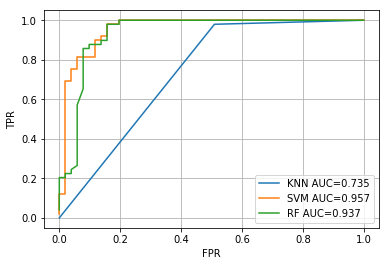

In [13]:
from sklearn.metrics import roc_curve

plt.figure()

fpr, tpr, _ = roc_curve(labels_test, ypred_knn, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="KNN AUC=" + "{:.3f}".format(auc))

fpr, tpr, _ = roc_curve(labels_test, ypred_svm, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="SVM AUC=" + "{:.3f}".format(auc))

fpr, tpr, _ = roc_curve(labels_test, ypred_rf, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="RF AUC=" + "{:.3f}".format(auc))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show()

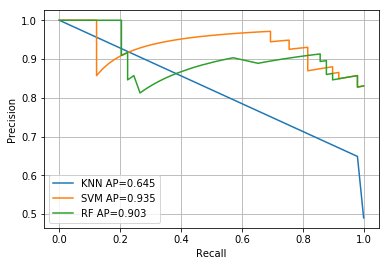

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure()

p, r, _ = precision_recall_curve(labels_test, ypred_knn, pos_label=1)
ap = average_precision_score(labels_test, ypred_knn)
plt.plot(r, p, label="KNN AP=" + "{:.3f}".format(ap))

p, r, _ = precision_recall_curve(labels_test, ypred_svm, pos_label=1)
ap = average_precision_score(labels_test, ypred_svm)
plt.plot(r, p, label="SVM AP=" + "{:.3f}".format(ap))

p, r, _ = precision_recall_curve(labels_test, ypred_rf, pos_label=1)
ap = average_precision_score(labels_test, ypred_rf)
plt.plot(r, p, label="RF AP=" + "{:.3f}".format(ap))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend()
plt.show()